<a href="https://colab.research.google.com/github/nadje/Parkinsons-Disease-Classification/blob/main/dataset2_classification_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn import datasets, metrics
from sklearn.metrics import confusion_matrix as CM

from sklearn.preprocessing import StandardScaler #importa el módulo para estandarizar
from sklearn.decomposition import PCA #importa el módulo para hacer análisis de componentes principales (PCA)
from sklearn.model_selection import train_test_split #importa el paquete para hacer el split training-test
from sklearn.linear_model import LogisticRegression #importa el paquete para hacer Logistic Regression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier #importa el paquete para hacer modelos ensemble
from sklearn.ensemble import GradientBoostingClassifier #importa el paquete para hacer Gradient Boosting
from sklearn.neighbors import KNeighborsClassifier #importa el paquete para usar el clasificador k-NN 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve,precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import precision_recall_curve #importa la curva precision-recall 
import bisect #importa el módulo para dar soporte a mantener una lista en orden sin tener que hacer sort después de cada inserción
from scipy.stats import mstats #importa módulo para evaluar objetos estadísticos
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn import tree
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import FastICA
from sklearn.metrics import accuracy_score, log_loss
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
url = 'https://raw.githubusercontent.com/nadje/Parkinsons-Disease-Classification/main/pd_speech_features.csv'
dat = pd.read_csv(url)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [ ]:
dat.head(10)

id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   
5   1       0  0.50780  0.78744  0.65451        226               221   
6   2       1  0.76095  0.62145  0.54543        322               321   
7   2       1  0.83671  0.62079  0.51179        318               317   
8   2       1  0.80826  0.61766  0.50447        318               317   
9   3       0  0.85302  0.62247  0.54855        493               492   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0.002669       0.00535  ...   
5          0.007631            0.002696       0.00783  ...   
6          0.005991            0.000107       0.00222  ...   
7          0.006074            0.000136       0.00282  ...   
8          0.006057            0.000069       0.00161  ...   
9          0.003910            0.000040       0.00075  ...   

   tqwt_kurtosisValue_dec_28  tqwt_kurtosisValue_dec_29  \
0                     1.5620                     2.6445   
1                     1.5589                     3.6107   
2                     1.5643                     2.3308   
3                     3.7805                     3.5664   
4                     6.1727                     5.8416   
5                     4.8025                     5.0734   
6                   117.2678                    75.3156   
7                     3.8564                    11.8909   
8                     2.2640                     6.3993   
9                     1.6796                     2.0474   

   tqwt_kurtosisValue_dec_30  tqwt_kurtosisValue_dec_31  \
0                     3.8686                     4.2105   
1                    23.5155                    14.1962   
2                     9.4959                    10.7458   
3                     5.2558                    14.0403   
4                     6.0805                     5.7621   
5                     7.0166                     5.9966   
6                    32.0478                     7.7060   
7                     7.2891                     4.3682   
8                     4.4165                     4.2662   
9                     2.8117                     3.5070   

   tqwt_kurtosisValue_dec_32  tqwt_kurtosisValue_dec_33  \
0                     5.1221                     4.4625   
1                    11.0261                     9.5082   
2                    11.0177                     4.8066   
3                     4.2235                     4.6857   
4                     7.7817                    11.6891   
5                     5.2065                     7.4246   
6                     3.1060                     4.6206   
7                     3.6443                     5.9610   
8                     3.6357                     3.7346   
9                     3.2727                     3.8415   

   tqwt_kurtosisValue_dec_34  tqwt_kurtosisValue_dec_35  \
0                     2.6202                     3.0004   
1                     6.5245                     6.3431   
2                     2.9199                     3.1495   
3                     4.8460                     6.2650   
4                     8.2103                     5.0559   
5                     3.4153                     3.5046   
6                    12.8353                    13.8300   
7                    11.7552                    18.0927   
8                     2.9394       

# Análisis exploratorio de los datos


## Definición de algunas funciones generales para representar los datos y generar descriptivos

In [ ]:
def pie_chart(perc):
  '''
  esta función representa un gráfico de sectores dados los porcentajes 
  de cada clase del dataset
  IN
  perc: una lista con los porcentakes de las dos clases
  '''
  explode = (0, 0.2)
  labels_ = ['Parkinson', 'Controls']
  fig, ax = plt.subplots(figsize=(8,8))
  ax.pie(perc, explode=explode, labels=labels_, autopct='%1.4f%%',
        shadow=False, startangle=90)
  plt.title("Class percentages in the dataset")
  plt.show()

def exploratory_analysis(df):
  '''
  esta función aplica una serie de análisis exploratorios
  IN
  df: el dataframe de pandas dataframe con el dataset
  '''
  parkinson = len(df['class'][df['class'] == 1])
  control = len(df['class'][df['class'] == 0])
  print("Shape of dataframe: ", df.shape, "\n", "Total rows: ", len(df) , "\n", 
        "Missing values: ", df.isna().sum().any(), "\n" , 
        "Total parkinson: ", parkinson, " --> ", 
        round(parkinson*100/len(df),4), "% \n", 
        "Total control: ", control, " --> ",
        round(control*100/len(df),4), "%")
  pie_chart([round(parkinson*100/len(df),4),round(control*100/len(df),4)])
  print("---------------------------------------")
  print("Columns and data types: ", df.info())
  print("---------------------------------------")
  print(df.describe())

def plot_features(df, class_name, column1, column2):
  '''
  función para representar dos variables frente otra (estado salud)
  IN
  df: dataframe de pandas dataframe con el dataset
  class_name: el nombre de la columna target (string)
  column1: columna con la primera variable a plotear
  column2: columna con la segunda variable a plotear
  '''
  fig, ax = plt.subplots(figsize=(10,10))
  plt.scatter(df[column1][df[class_name] == 0], 
              df[column2][df[class_name] == 0], 
              label="controls", alpha=0.5, linewidth=0.15, c='limegreen')
  plt.scatter(df[column1][df[class_name] == 1], 
              df[column2][df[class_name] == 1], 
              label="parkinson", alpha=0.5, linewidth=0.15, c='purple')
  plt.legend()
  plt.axis('off')
  plt.title("2D representation of Data \n Columns: " + str(column1) + "and" + 
            str(column2))
  plt.show()

def hist_correlation_analysis(df):
  '''
  histogramas y análisis de correlación entre variables
  IN
  df: dataframe de pandas dataframe con el dataset 
  '''
  df.hist(bins=50, figsize=(20,15))
  plt.title('Histograms', fontsize=16)
  plt.show()
  f = plt.figure(figsize=(19, 30))
  plt.matshow(df.drop(["class"],axis = 1).corr(), fignum=f.number)
  plt.xticks(range(df.drop(["class"],axis = 1).select_dtypes(['number']).shape[1]), df.drop(["class"],axis = 1).select_dtypes(['number']).columns, fontsize=20, rotation=45)
  plt.yticks(range(df.drop(["class"],axis = 1).select_dtypes(['number']).shape[1]), df.drop(["class"],axis = 1).select_dtypes(['number']).columns, fontsize=20)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=20)
  plt.title('Correlation Matrix', fontsize=16)
  sns.pairplot(df)

def boxplots_plot (df, colnames):
  '''
  representación de boxplot para identificar outliers o variables con dispersión
  df: dataframe de pandas dataframe con el dataset
  colnames: qué variables plotear
  '''
  for col in colnames:
    sns.boxplot(y = dat['class'].astype('category'), x = col, data=dat)
    plt.show()

def plot_cor_matrix(corr, mask=True):

  '''
  matriz de la correlación con significance masking
  Idealmente, para correrla por separado para parkinson y control
  corr: el dataset a introducir en la correlación (i.e., df.corr())
  '''
  f, ax = plt.subplots(figsize=(11, 9))
  sns.heatmap(corr, ax=ax,
               mask=mask,
               # cosmetics
              annot=True, vmin=-1, vmax=1, center=0,
              cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})
    
def corr_sig(df=None):
  '''
  matriz de la correlación con significance masking
  Idealmente, para correrla por separado para parkinson y control
  corr: el dataset a introducir en la correlación (i.e., df.corr())
  '''
  p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
  for col in df.columns:
      for col2 in df.drop(col,axis=1).columns:
        _ , p = stats.pearsonr(df[col],df[col2])
        p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
        return p_matrix

## Gráfico de sectores y estadísticos descriptivos

Shape of dataframe:  (756, 755) 
 Total rows:  756 
 Missing values:  False 
 Total parkinson:  564  -->  74.6032 % 
 Total control:  192  -->  25.3968 %


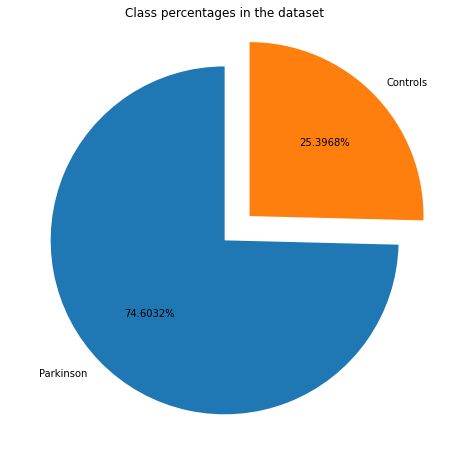

---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB
Columns and data types:  None
---------------------------------------
               id      gender         PPE         DFA        RPDE   numPulses  \
count  756.000000  756.000000  756.000000  756.000000  756.000000  756.000000   
mean   125.500000    0.515873    0.746284    0.700414    0.489058  323.972222   
std     72.793721    0.500079    0.169294    0.069718    0.137442   99.219059   
min      0.000000    0.000000    0.041551    0.543500    0.154300    2.000000   
25%     62.750000    0.000000    0.762833    0.647053    0.386537  251.000000   
50%    125.500000    1.000000    0.809655    0.700525    0.484355  317.000000   
75%    188.250000    1.000000    0.834315    0.754985    0.586515  384.250000   
max    251.000000    1.000000    0.907660    0.852640    0.871230  907.000000   

  

In [ ]:
exploratory_analysis(dat)

## Estadísticos descriptivos separados por grupo

In [ ]:
dat.groupby('class').mean()

id    gender       PPE       DFA      RPDE   numPulses  \
class                                                                   
0      139.421875  0.359375  0.767434  0.663866  0.430807  372.244792   
1      120.760638  0.569149  0.739084  0.712856  0.508888  307.539007   

       numPeriodsPulses  meanPeriodPulses  stdDevPeriodPulses  locPctJitter  \
class                                                                         
0            371.031250          0.005699            0.000290      0.001405   
1            306.218085          0.006585            0.000414      0.002637   

       ...  tqwt_kurtosisValue_dec_27  tqwt_kurtosisValue_dec_28  \
class  ...                                                         
0      ...                  47.053772                  45.754404   
1      ...                  12.165554                  19.593113   

       tqwt_kurtosisValue_dec_29  tqwt_kurtosisValue_dec_30  \
class                                                         
0                      32.006881                  21.592319   
1                      19.719812                  17.565102   

       tqwt_kurtosisValue_dec_31  tqwt_kurtosisValue_dec_32  \
class                                                         
0                      14.797452                  10.726868   
1                      13.556976                  12.726897   

       tqwt_kurtosisValue_dec_33  tqwt_kurtosisValue_dec_34  \
class                                                         
0                       9.021939                   9.619535   
1                      13.516916                  16.562531   

       tqwt_kurtosisValue_dec_35  tqwt_kurtosisValue_dec_36  
class                                                        
0                       9.326543                  15.074830  
1                      16.598373                  37.066227  

[2 rows x 754 columns]

- Las variables numPulses y numPeriodsPulses tienen estadísticos muy similares
- Las variables IOCPCTJitter y IoCABSJitter también altamente correlacionadas; alguna de las dos podría eliminarse. 
- Las variables ppq5jitter y ddpjitter están altamente relacionadas. Lo mismo con las variables IOCShimmer y IOCDBShimmer. 
--> En general, parece que hay varias variables que indican cosas similares y podrían eliminarse para reducir la complejidad del modelo. 

### Género 

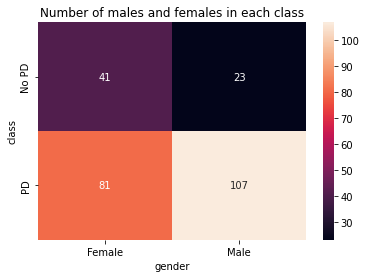

In [ ]:
sns.heatmap(pd.crosstab(dat['class'], dat['gender']).divide(3).astype('int64'), 
            yticklabels=['No PD', 'PD'],
            xticklabels=['Female', 'Male'],
            annot=True,
            fmt='d')
plt.title('Number of males and females in each class')
plt.show()

Tenemos:

- 41 mujeres y 23 hombres sin Parkinson
- 81 mujeres y 107 hobres con Parkinson

- Los hombres están infra-representados en el grupo sin Parkinson. 
- Las mujeres están infra-representadas en el grupo Parkinson. 

### Gráficos de barra para cada variable en función de estado

In [ ]:
feat = [col for col in dat.columns if col not in ['id', 'class']]
# barplot to all the continous features (target variable status on x-axis, continous features on y-axis)
# 0 -> magenta, 1 -> orange 
ncols = 7
nrows = int(len(feat) / ncols + (len(feat) % ncols > 0))-1

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 30), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = feat[r*ncols+c]
        sns.barplot(y=dat[col], x=dat['class'], ax=axes[r, c], palette='Set2', label='Train data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=12, fontweight='bold')
        axes[r, c].tick_params(labelsize=12, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

## Análisis de correlación e histogramas

In [ ]:
hist_correlation_analysis(dat)

In [ ]:
dat.head(10)

id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   
5   1       0  0.50780  0.78744  0.65451        226               221   
6   2       1  0.76095  0.62145  0.54543        322               321   
7   2       1  0.83671  0.62079  0.51179        318               317   
8   2       1  0.80826  0.61766  0.50447        318               317   
9   3       0  0.85302  0.62247  0.54855        493               492   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0.002669       0.00535  ...   
5          0.007631            0.002696       0.00783  ...   
6          0.005991            0.000107       0.00222  ...   
7          0.006074            0.000136       0.00282  ...   
8          0.006057            0.000069       0.00161  ...   
9          0.003910            0.000040       0.00075  ...   

   tqwt_kurtosisValue_dec_28  tqwt_kurtosisValue_dec_29  \
0                     1.5620                     2.6445   
1                     1.5589                     3.6107   
2                     1.5643                     2.3308   
3                     3.7805                     3.5664   
4                     6.1727                     5.8416   
5                     4.8025                     5.0734   
6                   117.2678                    75.3156   
7                     3.8564                    11.8909   
8                     2.2640                     6.3993   
9                     1.6796                     2.0474   

   tqwt_kurtosisValue_dec_30  tqwt_kurtosisValue_dec_31  \
0                     3.8686                     4.2105   
1                    23.5155                    14.1962   
2                     9.4959                    10.7458   
3                     5.2558                    14.0403   
4                     6.0805                     5.7621   
5                     7.0166                     5.9966   
6                    32.0478                     7.7060   
7                     7.2891                     4.3682   
8                     4.4165                     4.2662   
9                     2.8117                     3.5070   

   tqwt_kurtosisValue_dec_32  tqwt_kurtosisValue_dec_33  \
0                     5.1221                     4.4625   
1                    11.0261                     9.5082   
2                    11.0177                     4.8066   
3                     4.2235                     4.6857   
4                     7.7817                    11.6891   
5                     5.2065                     7.4246   
6                     3.1060                     4.6206   
7                     3.6443                     5.9610   
8                     3.6357                     3.7346   
9                     3.2727                     3.8415   

   tqwt_kurtosisValue_dec_34  tqwt_kurtosisValue_dec_35  \
0                     2.6202                     3.0004   
1                     6.5245                     6.3431   
2                     2.9199                     3.1495   
3                     4.8460                     6.2650   
4                     8.2103                     5.0559   
5                     3.4153                     3.5046   
6                    12.8353                    13.8300   
7                    11.7552                    18.0927   
8                     2.9394       

# Pretratamiento de los datos

## Imbalance treatment using SMOTE
- Tenemos un dataset desbalanceado. 


Podemos usar SMOTE para contrarestarlo:

- SMOTE (Synthetic Minority Oversampling Technique) funciona seleccionando aleatoriamente un punto de la clase minoritaria y computando los k-nearest neighbors para dicho punto. Los puntos sintéticos se añaden entre el punto elegido y sus vecinos. 

- El algoritmo SMOTE funciona en 4 pasos simples: 
  - Se pasa la clase minoritaria como el vector de input
  - Encuentra sus k-nearest neighbors (este valor se especifica como argumento en la función SMOTE())
  - Elige uno de esos vecinos y coloca un punto sintético en algún lugar en la línea que une el punto en cuestión y su vecino elegido. 
  - Repite los pasos hasta que los datos están balanceados.



In [ ]:
datNum=dat.drop('class', axis=1)
datNum=datNum.drop('id', axis=1)

y=dat[['class']]

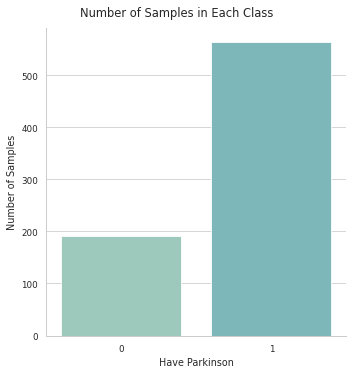

In [ ]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('GnBu_d')
a = sns.catplot(x='class', data=dat, kind='count')
a.fig.suptitle('Number of Samples in Each Class', y=1.03)
a.set(ylabel='Number of Samples', xlabel='Have Parkinson')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

x_resample, y_resample  = SMOTE().fit_resample(datNum.iloc[:,:-1], dat['class'])

# lets print the shape of x and y after resampling it
print(x_resample.shape)
print(y_resample.shape)

(1128, 752)
(1128,)


In [ ]:
print("Before Resampling :")
print(y.value_counts())

print("After Resampling :")
print(np.bincount(y_resample))

Before Resampling :
class
1        564
0        192
dtype: int64
After Resampling :
[564 564]


# División del dataset en train y test

In [ ]:
#x=dat.drop('class', axis=1)
#y=dat[['class']]

# if I use SMOTE: 
y = y_resample 
x = x_resample

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_resample, y_resample, test_size=0.2, random_state=12)
print(x_resample.shape, x_train.shape, x_test.shape)
print(y_resample.shape, y_train.shape, y_test.shape)

(1128, 752) (902, 752) (226, 752)
(1128,) (902,) (226,)


# Estandarización

In [ ]:
from sklearn.preprocessing import RobustScaler
#features=data.loc[:,dat.columns!='status'].values[:,1:]
#labels=data.loc[:,'status'].values
#scaler=MinMaxScaler((-1,1)) # minmax ?
scaler = StandardScaler()
#scaler = RobustScaler() # using statistics robust to outliers
x_train=scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Modelos

In [ ]:
conf_matrix_all = {}
# de https://www.kaggle.com/code/adityakadiwal/parkinsons-disease-detection

def parkinsons_disease_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Hacer Fit del training data set al algoritmo pasado.
    predictions = algo.predict(testing_x)                     # Obtener las predicciones
    probabilities = algo.predict_proba(testing_x)             # Obtener las probabilidades de las predicciones

    conf_matrix = confusion_matrix(testing_y, predictions)    # Obtener la matriz de confusión
    tn, fp, fn, tp = conf_matrix.ravel()
    
    conf_matrix_all[name] = conf_matrix                       # Guardar la matriz de confusión en un diccionario
    
    print("Classification report:")                           # Imprimir el informe de clasificación
    print(classification_report(testing_y, predictions))

    print("\nSensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)")
    print(tp / (tp + fn))

    print("\nSpecificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)")
    print(tn / (tn + fn))

    model_roc_auc = roc_auc_score(testing_y, predictions)           # Obtener el área bajo la curva
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Obtener los False postive rate y True positive rate
    accuracy = (tp+tn)/(tn+tp+fn+fp)
    
    print ("\nArea under the curve: ", model_roc_auc)
    
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(20, 7))
        conf_matrix = np.flip(conf_matrix)
        plt.rcParams.update({'font.size': 22})

        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)
        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[0], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);                                           # Plot the confusion matrix
        axes[0].set(xlabel='Predicted', ylabel='Actual')

        plt.title('Receiver Operating Characteristic')
        sns.lineplot(fpr, tpr, ax=axes[1])                                         # Graficar la curva ROC
        plt.plot([0, 1], [0, 1],'--')                                              # Graficar la línea diagonal
        axes[1].set_xlim([0, 1])                                                   # Poner el límite del eje X en 0 y 1
        axes[1].set_ylim([0, 1])                                                   # Poner el límite del eje Y en 0 y 1
        axes[1].set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate');
        plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
        plt.show();
    return model_roc_auc, accuracy

## KNN

Classification report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       116
           1       1.00      0.93      0.96       110

    accuracy                           0.96       226
   macro avg       0.97      0.96      0.96       226
weighted avg       0.97      0.96      0.96       226


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9272727272727272

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.9354838709677419

Area under the curve:  0.9636363636363636


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


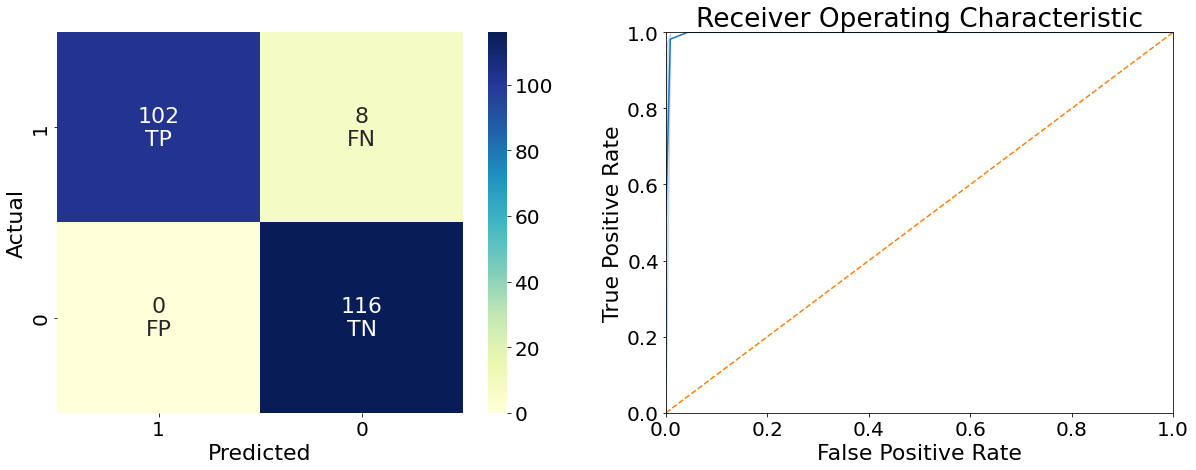

In [ ]:
#knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')
knn = KNeighborsClassifier(algorithm='brute', leaf_size=21, metric='manhattan', metric_params=None, n_neighbors = 4, weights='distance') # with values from optuna (see end)
auc_knn, acc_knn = parkinsons_disease_prediction("K-Nearest Neighbours", knn, x_train, x_test, y_train, y_test, plot=True)

## Support vector machine

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       116
           1       0.97      0.89      0.93       110

    accuracy                           0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.94      0.93      0.93       226


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.8909090909090909

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.904

Area under the curve:  0.9325235109717868


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


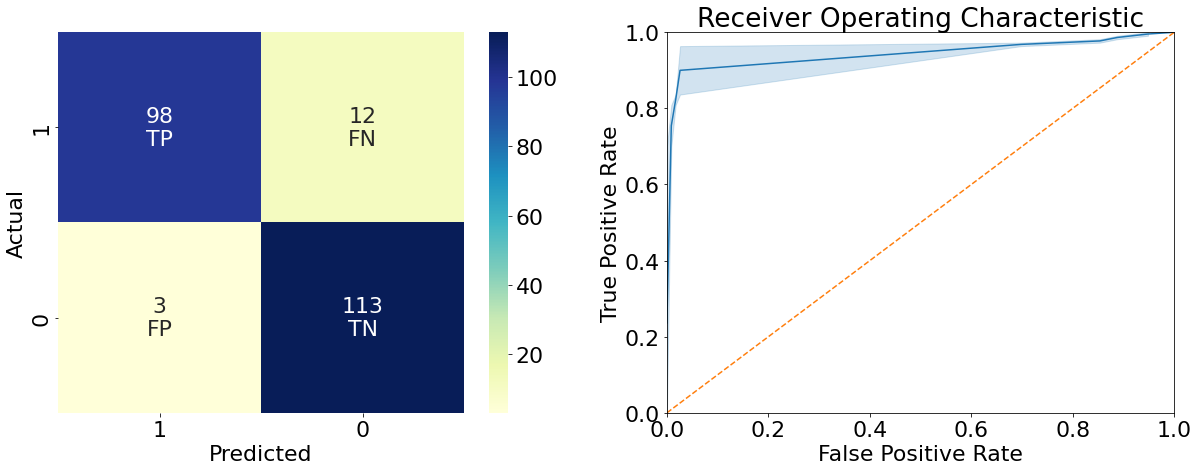

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=1.0, kernel='linear', degree= 2, gamma=1.0, random_state=None,
          coef0=0.0, shrinking=True, probability=True,tol=0.001,
          cache_size=200, class_weight=None, verbose=False,max_iter= -1)

auc_svm, acc_svm =parkinsons_disease_prediction("Support Vector Classifier", svc1, x_train, x_test, y_train, y_test, plot=True)

## Naive Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       116
           1       0.81      0.81      0.81       110

    accuracy                           0.81       226
   macro avg       0.81      0.81      0.81       226
weighted avg       0.81      0.81      0.81       226


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.8090909090909091

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.8189655172413793

Area under the curve:  0.8140282131661443


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


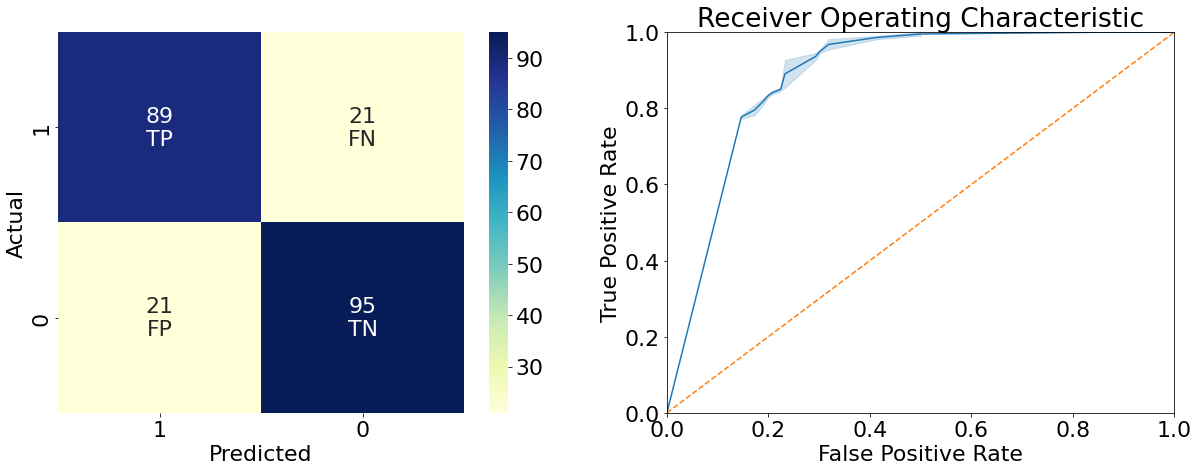

In [ ]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)
auc_nb, acc_nb =parkinsons_disease_prediction("Gaussian Naïve Bayes", gnb, x_train, x_test, y_train, y_test, plot=True)

## Random forest

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       116
           1       0.97      0.89      0.93       110

    accuracy                           0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.94      0.93      0.93       226


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.8909090909090909

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.904

Area under the curve:  0.9325235109717868


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


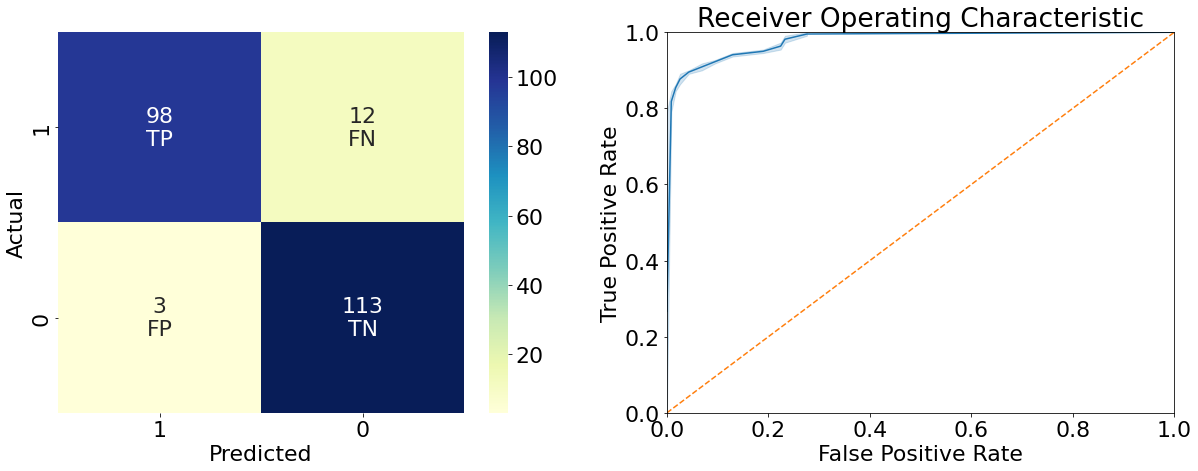

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, criterion = "gini", 
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

auc_rf, acc_rf = parkinsons_disease_prediction("Random Forest", rfc,x_train, x_test, y_train, y_test, plot=True) 

## Bagging Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       116
           1       0.96      0.85      0.90       110

    accuracy                           0.91       226
   macro avg       0.92      0.91      0.91       226
weighted avg       0.92      0.91      0.91       226


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.8545454545454545

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.875

Area under the curve:  0.9100313479623825


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


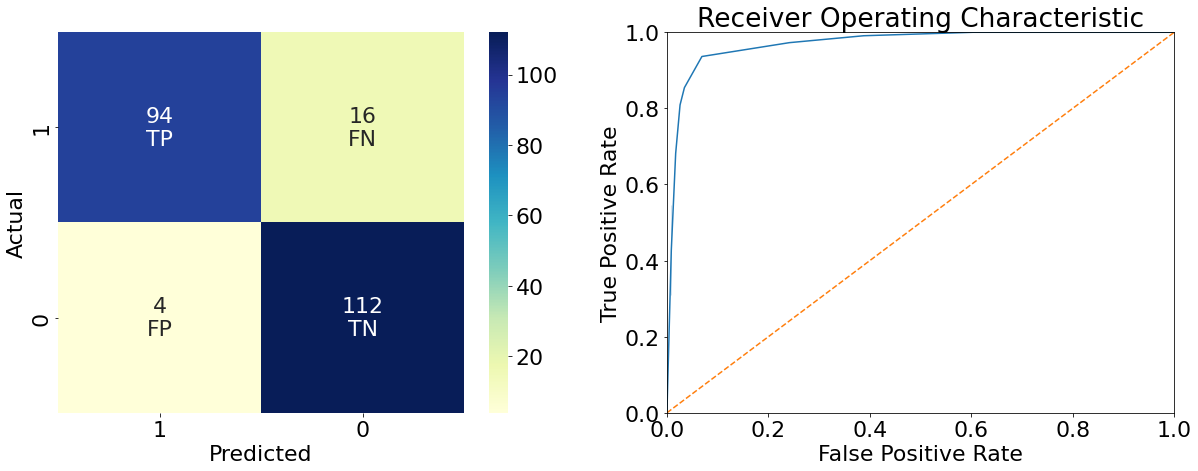

In [ ]:
bcc = BaggingClassifier()

auc_bc, acc_bc = parkinsons_disease_prediction("Bagging Classifier", bcc,x_train, x_test, y_train, y_test, plot=True) 

## XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       116
           1       0.96      0.94      0.95       110

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.95      0.95      0.95       226


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9363636363636364

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.9411764705882353

Area under the curve:  0.9509404388714734


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


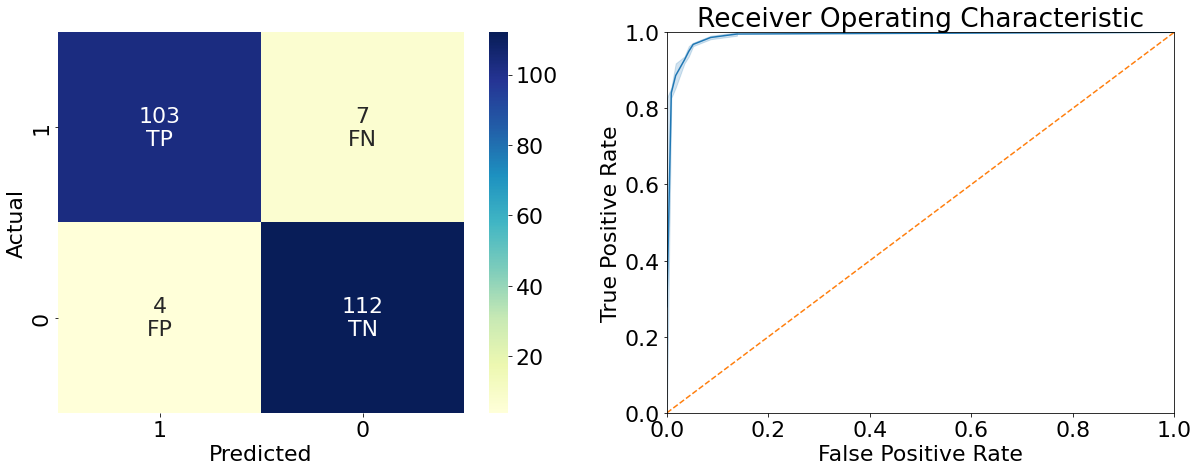

In [ ]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth = 6, min_child_weight=1, missing=None, n_estimators=50,
                        objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, subsample = 0.8)
auc_xgb, acc_xgb = parkinsons_disease_prediction("XGBoost", xgb,x_train, x_test, y_train, y_test, plot=True) 

## Cat boost

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 83 kB/s 


Learning rate set to 0.009858
0:	learn: 0.6866656	total: 566ms	remaining: 9m 25s
1:	learn: 0.6806730	total: 1.03s	remaining: 8m 32s
2:	learn: 0.6746764	total: 1.43s	remaining: 7m 54s
3:	learn: 0.6675783	total: 1.75s	remaining: 7m 16s
4:	learn: 0.6618760	total: 1.96s	remaining: 6m 30s
5:	learn: 0.6558535	total: 2.18s	remaining: 6m 1s
6:	learn: 0.6507278	total: 2.39s	remaining: 5m 39s
7:	learn: 0.6439594	total: 2.62s	remaining: 5m 24s
8:	learn: 0.6381282	total: 2.83s	remaining: 5m 11s
9:	learn: 0.6329099	total: 3.03s	remaining: 5m
10:	learn: 0.6276198	total: 3.25s	remaining: 4m 52s
11:	learn: 0.6216361	total: 3.47s	remaining: 4m 46s
12:	learn: 0.6162968	total: 3.69s	remaining: 4m 39s
13:	learn: 0.6112231	total: 3.9s	remaining: 4m 34s
14:	learn: 0.6062171	total: 4.11s	remaining: 4m 29s
15:	learn: 0.6021705	total: 4.32s	remaining: 4m 25s
16:	learn: 0.5967818	total: 4.54s	remaining: 4m 22s
17:	learn: 0.5909298	total: 4.75s	remaining: 4m 19s
18:	learn: 0.5867603	total: 4.97s	remaining: 4m 16

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


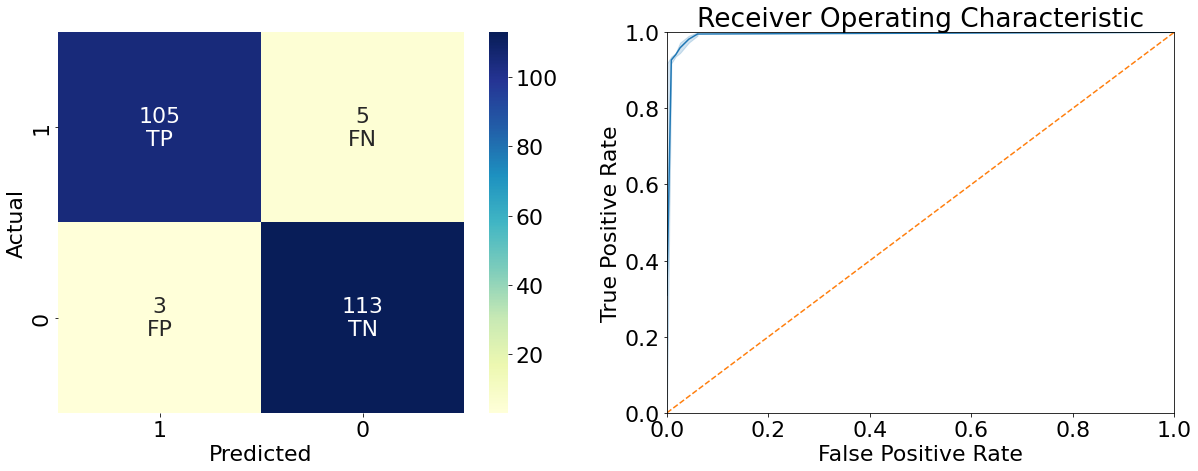

In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(depth=6)
auc_cat, acc_cat = parkinsons_disease_prediction("Cat Boost", cb, x_train, x_test, y_train, y_test, plot=True)

## Resumen de las performances de todos los modelos

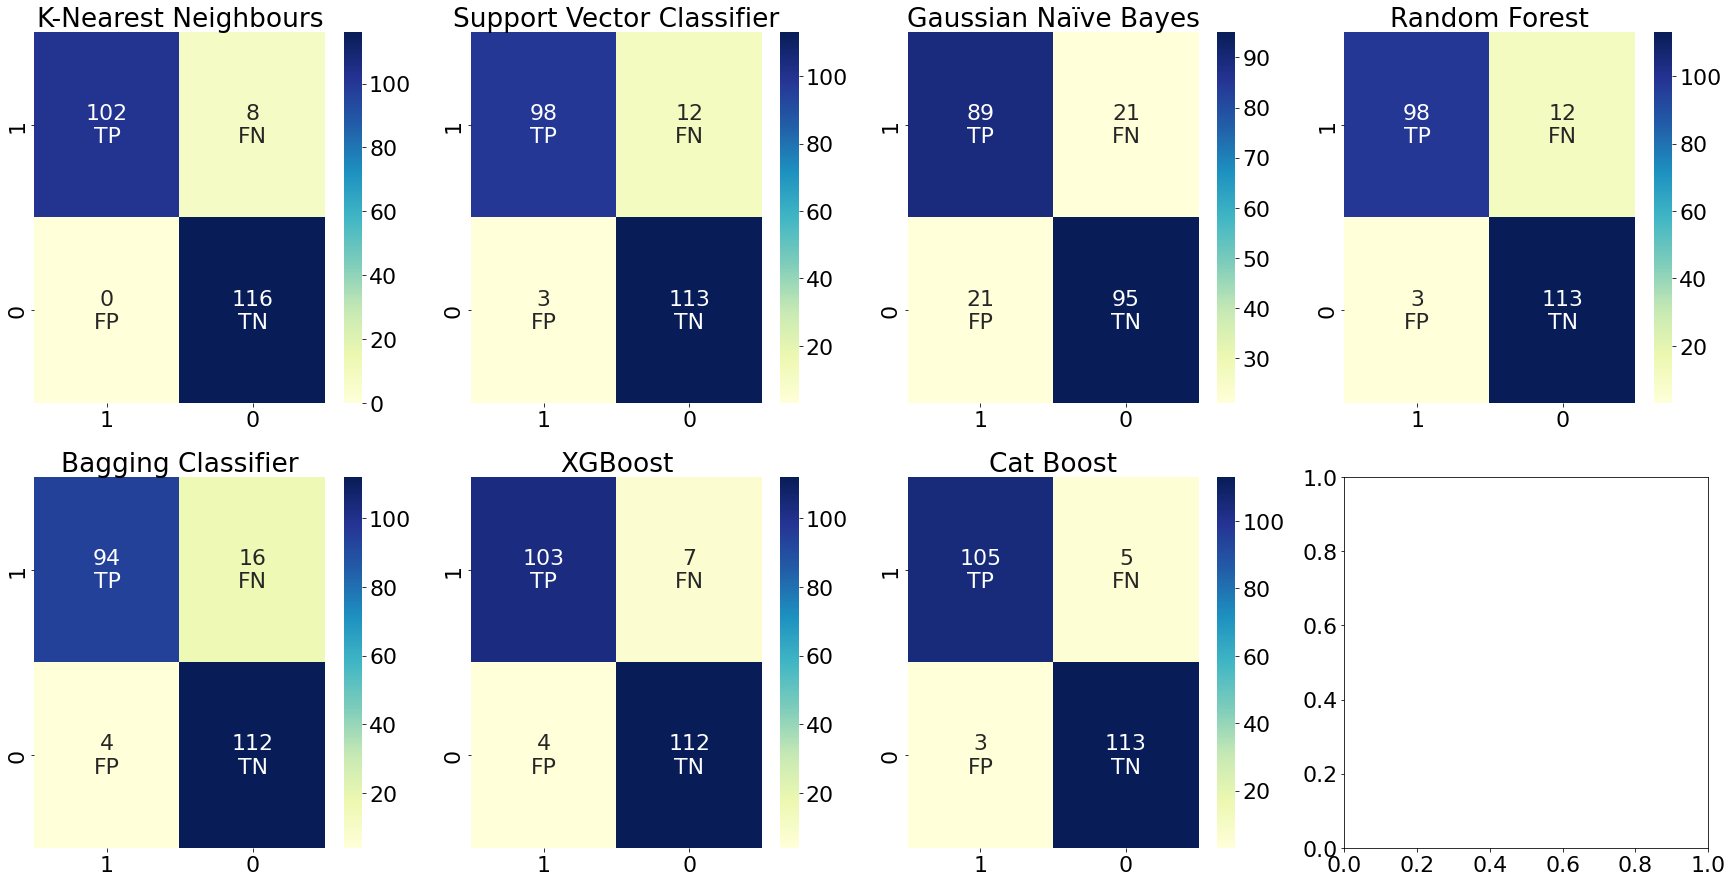

In [ ]:
import math
fig, axes = plt.subplots(2, 4, figsize = (30, 15))

acc = [acc_knn, acc_svm, acc_nb, acc_rf, acc_bc, acc_xgb, acc_cat]

cnt = 0
for r in range(4):
    for c in range(4):
        try:
            conf_matrix = np.flip(list(conf_matrix_all.values())[cnt])
            labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
            labels = np.core.defchararray.add(conf_matrix.astype(str), labels)

            sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[r, c], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);
            axes[r, c].set(title=list(conf_matrix_all.keys())[cnt])
            cnt += 1
        except:
            pass

In [ ]:
print('ACCURACIES:\n KNN = '+str(acc_knn) + '\n SVM = '+str(acc_svm) + '\n NB = '+str(acc_nb) + '\n RF = '+str(acc_rf) + '\n BC = '+str(acc_bc) + '\n XGB = '+str(acc_xgb) + '\n Catboost = ' + str(acc_cat))
print('\n')
print('AREA UNDER THE CURVE:\n KNN = '+str(auc_knn) + '\n SVM = '+str(auc_svm) + '\n NB = '+str(auc_nb) + '\n RF = '+str(auc_rf) + '\n BC = '+str(auc_bc) + '\n XGB = '+str(auc_xgb) +'\n Catboost = ' + str(auc_cat))

ACCURACIES:
 KNN = 0.9646017699115044
 SVM = 0.9336283185840708
 NB = 0.8141592920353983
 RF = 0.9336283185840708
 BC = 0.911504424778761
 XGB = 0.9513274336283186
 Catboost = 0.9646017699115044


AREA UNDER THE CURVE:
 KNN = 0.9636363636363636
 SVM = 0.9325235109717868
 NB = 0.8140282131661443
 RF = 0.9325235109717868
 BC = 0.9100313479623825
 XGB = 0.9509404388714734
 Catboost = 0.9643416927899686


# Conclusión:

- KNN y Catboost dan la mejor accuracy (0.96) pero Catboost da ROC más alta que KNN (ROC-Catboost: 0.9643 y ROC-KNN: 0.9636)